In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


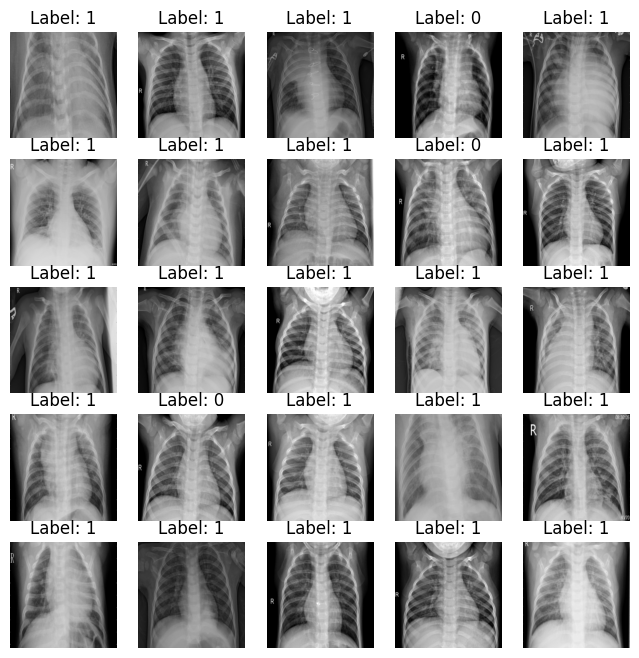

In [ ]:
import matplotlib.pyplot as plt
import torch

figure = plt.figure(figsize=(8, 8))
cols, rows = 5, 5  # Number of columns and rows for the grid

for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(dataset), size=(1,)).item()
    img, label = dataset[sample_idx]

    ax = figure.add_subplot(rows, cols, i)
    plt.axis("off")

    if img.shape[0] == 1:
        img = img.squeeze()
        plt.imshow(img, cmap="gray")
    else:
        img = img.permute(1, 2, 0).numpy()
        plt.imshow(img)

    ax.set_title(f"Label: {label}")

plt.show()


In [ ]:
import torchvision

train_transforms = transforms.Compose([transforms.Resize((224,224)),
                                      transforms.Grayscale(num_output_channels=1),
                                       transforms.ToTensor(),
                                       torchvision.transforms.Normalize(
                                          #  mean=[0.4815, 0.4815, 0.4815],
                                          #  std=[0.2221, 0.2221, 0.2221],
                                          mean=[0.4815],
                                          std=[0.255]
    ),
                                       ])
test_transforms = transforms.Compose([transforms.Resize((224,224)),
                                      transforms.Grayscale(num_output_channels=1),
                                      transforms.ToTensor(),
                                      torchvision.transforms.Normalize(
                                          mean=[0.4815],
                                          std=[0.255]
    ),
                                      ])

traindir = '/content/drive/MyDrive/zoidberg/chest_Xray/train'
testdir = '/content/drive/MyDrive/zoidberg/chest_Xray/test'
valdir = '/content/drive/MyDrive/zoidberg/chest_Xray/val'

#datasets
train_data = datasets.ImageFolder(traindir,transform=train_transforms)
test_data = datasets.ImageFolder(testdir,transform=test_transforms)
val_data = datasets.ImageFolder(valdir,transform=train_transforms)

#dataloader
trainloader = torch.utils.data.DataLoader(train_data, shuffle = True, batch_size=64)
testloader = torch.utils.data.DataLoader(test_data, shuffle = True, batch_size=64)
valloader = torch.utils.data.DataLoader(val_data, shuffle = True, batch_size=64)

In [ ]:
from torch import nn

class NeuralNetwork(nn.Module):
    def __init__(self, hidden_size=512):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(224*224, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 2),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits


In [ ]:
'https://www.dataquest.io/blog/pytorch-for-beginners/'

# Cross entropy commonly use for classification problems
loss_function = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

In [ ]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        pred = model(X)
        loss = loss_fn(pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 10 == 0:
            loss_value = loss.item()
            current = batch * len(X)
            print(f"loss: {loss_value:>7f}  [{current:>5d}/{size:>5d}]")


def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    model.eval()
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return correct

In [ ]:
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(trainloader, model, loss_function, optimizer)
    test(testloader, model, loss_function)
print("Done!")

In [ ]:
test(testloader, model, loss_function)


Test Error: 
 Accuracy: 78.4%, Avg loss: 0.631379 



0.7836538461538461

In [ ]:
train(trainloader, model, loss_function, optimizer)
test(testloader, model, loss_function)


loss: 0.154273  [    0/ 5216]
loss: 0.077441  [  640/ 5216]
loss: 0.211118  [ 1280/ 5216]
loss: 0.083023  [ 1920/ 5216]
loss: 0.162021  [ 2560/ 5216]
loss: 0.270472  [ 3200/ 5216]
loss: 0.074180  [ 3840/ 5216]
loss: 0.052830  [ 4480/ 5216]
loss: 0.077707  [ 5120/ 5216]
Test Error: 
 Accuracy: 78.7%, Avg loss: 0.679361 



0.7868589743589743

In [ ]:
from sklearn.metrics import confusion_matrix

def ftest(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    all_preds = []
    all_labels = []

    model.eval()
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            all_preds.extend(pred.argmax(1).cpu().numpy())
            all_labels.extend(y.cpu().numpy())

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

    # Calculate confusion matrix
    conf_matrix = confusion_matrix(all_labels, all_preds)
    print("Confusion Matrix:\n", conf_matrix)

    return correct, conf_matrix

In [ ]:
res, cm = ftest(testloader, model, loss_function)

Test Error: 
 Accuracy: 78.7%, Avg loss: 0.671910 

Confusion Matrix:
 [[110 124]
 [  9 381]]


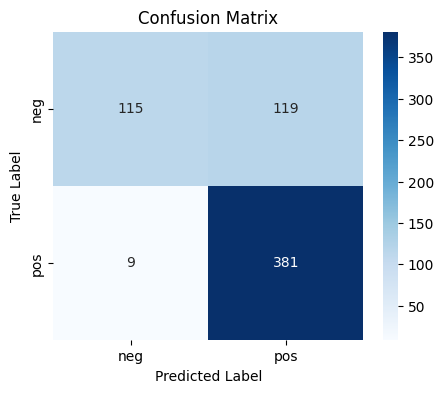

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_confusion_matrix(conf_matrix, class_names=['neg','pos']):
    plt.figure(figsize=(5, 4))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

plot_confusion_matrix(cm)



# **CNN**



In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self, l1=120, l2=84):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1)

        self.fc1 = nn.Linear(16 * 53 * 53, l1)
        self.fc2 = nn.Linear(l1, l2)
        self.fc3 = nn.Linear(l2, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Check if CUDA is available and use it
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

model = Net().to(device)
model

Using cpu device


Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=44944, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=1, bias=True)
)

In [ ]:
from sklearn.metrics import confusion_matrix

def new_test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    all_preds = []
    all_labels = []

    model.eval()
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device).view(-1, 1).float()  # Reshape labels and convert to float
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            predicted = (pred > 0.5).float()  # Apply threshold to get binary predictions
            correct += (predicted == y).type(torch.float).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(y.cpu().numpy())

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

    # Calculate confusion matrix
    conf_matrix = confusion_matrix(all_labels, all_preds)
    print("Confusion Matrix:\n", conf_matrix)

    return correct, conf_matrix

# Test the function
res, cm = new_test(testloader, model, criterion)


Test Error: 
 Accuracy: 79.5%, Avg loss: 0.653810 

Confusion Matrix:
 [[115 119]
 [  9 381]]


In [ ]:
import pickle

file = open('/content/drive/MyDrive/zoidberg/models/CNN(80%acc).pkl', 'wb')

# dump information to that file
pickle.dump(model, file)

# **Improve CNN**

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from sklearn.metrics import confusion_matrix

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

transform_train = transforms.Compose([
    transforms.Resize(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

transform_test = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

traindir = '/content/drive/MyDrive/zoidberg/chest_Xray/train'
testdir = '/content/drive/MyDrive/zoidberg/chest_Xray/test'

trainset = torchvision.datasets.ImageFolder(root=traindir, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)

testset = torchvision.datasets.ImageFolder(root=testdir, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)

# Define the model (using ResNet18)
import torchvision.models as models

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.resnet = models.resnet18(pretrained=True)
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, 1)

    def forward(self, x):
        x = self.resnet(x)
        x = torch.sigmoid(x)
        return x

model = Net().to(device)

# Loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Training function
def train_model(model, trainloader, criterion, optimizer, scheduler, num_epochs=10):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.view(-1, 1).float().to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(trainloader):.4f}')

        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for inputs, labels in testloader:
                inputs, labels = inputs.to(device), labels.view(-1, 1).float().to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                predicted = (outputs > 0.5).float()
                correct += (predicted == labels).sum().item()

                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        val_loss /= len(testloader)
        accuracy = 100 * correct / len(testloader.dataset)
        print(f'Validation Loss: {val_loss:.4f}, Accuracy: {accuracy:.2f}%')

        # Print confusion matrix
        conf_matrix = confusion_matrix(all_labels, all_preds)
        print("Confusion Matrix:\n", conf_matrix)

        scheduler.step()

    print('Finished Training')

train_model(model, trainloader, criterion, optimizer, scheduler, num_epochs=10)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 138MB/s]


Epoch [1/10], Loss: 0.2847
Validation Loss: 0.6636, Accuracy: 78.37%
Confusion Matrix:
 [[102 132]
 [  3 387]]
Epoch [2/10], Loss: 0.2028
Validation Loss: 0.4201, Accuracy: 85.42%
Confusion Matrix:
 [[152  82]
 [  9 381]]
Epoch [3/10], Loss: 0.1874
Validation Loss: 0.2675, Accuracy: 87.82%
Confusion Matrix:
 [[218  16]
 [ 60 330]]
Epoch [4/10], Loss: 0.1754
Validation Loss: 0.2617, Accuracy: 91.83%
Confusion Matrix:
 [[188  46]
 [  5 385]]


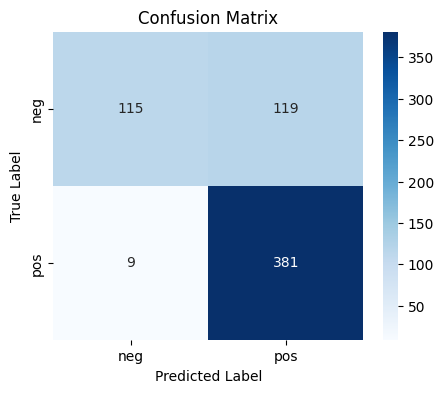

In [ ]:
plot_confusion_matrix(cm)

In [ ]:
model

NameError: name 'model' is not defined